# TP2 - Análise de Hiper-parâmetros no PSO
### EEE882 - Computação Evolucionária

#### Matheus Bitarães de Novaes

In [1]:
# imports para o problema
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import seaborn as sns

### Introdução

Neste notebook iremos explorar a analise de hiper-parâmetros utilianzado o PSO para as otimizações.


#### Tarefa 1:
Esta tarefa consiste em escolher e implementas duas funções de teste apresentadas na tabela abaixo, sendo uma delas unimodal e a outra multimodal.

https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf 

funções escolhidas:
- unimodal: Sphere Function
- multimodal: Rastrigin’s Function

#### Sphere Function 

In [2]:
# implementaçao em python adaptada do codigo em matlab disponivel em https://www.sfu.ca/~ssurjano/Code/spherefm.html
def spheref (x): #input x = [x1, x2, ...]
    y = 0
    f = -1400 # valor da tabela disponivel em https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf
    for i in range(0,len(x)):
        y = y + pow(x[i], 2)
    return y + f

<IPython.core.display.Javascript object>


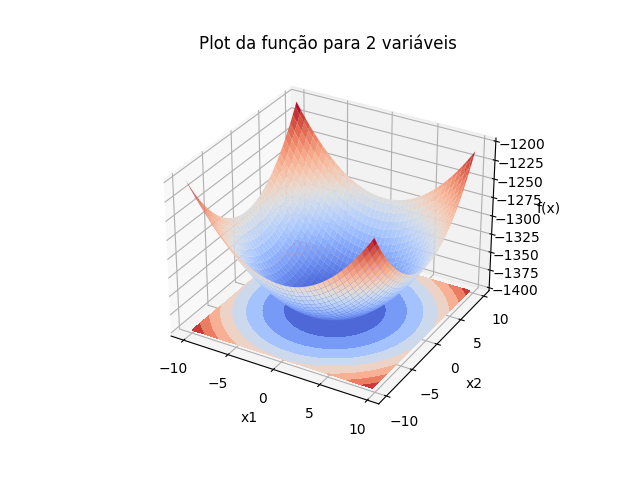

Text(0.5, 0, 'f(x)')

In [3]:
# plot da função para 2 variáveis
%matplotlib notebook

# variáveis
x1 = np.arange(-10, 10, 0.25)
x2 = np.arange(-10, 10, 0.25)
y = np.zeros((len(x1), len(x2)))
for i in range(0, len(x1)):
    for j in range (0, len(x2)):
        y[i][j] = spheref([x1[i], x2[j]])
        

# grid
x1, x2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot
surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

cset = ax.contourf(x1, x2, y, zdir='z', offset=-1400, cmap=cm.coolwarm)

ax.set_title('Plot da função para 2 variáveis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

#### Rastrigin’s Function

In [5]:
# implementaçao em python adaptada da funçao disponivel em https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf
def rastrf (x):
    y = 0
    f = -400 # valor da tabela disponivel em https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf
    for i in range(0, len(x)):
        y = y + pow(x[i], 2) - 10 * np.cos(2 * np.pi * x[i]) + 10
    return y + f

plot da função para duas variáveis

<IPython.core.display.Javascript object>


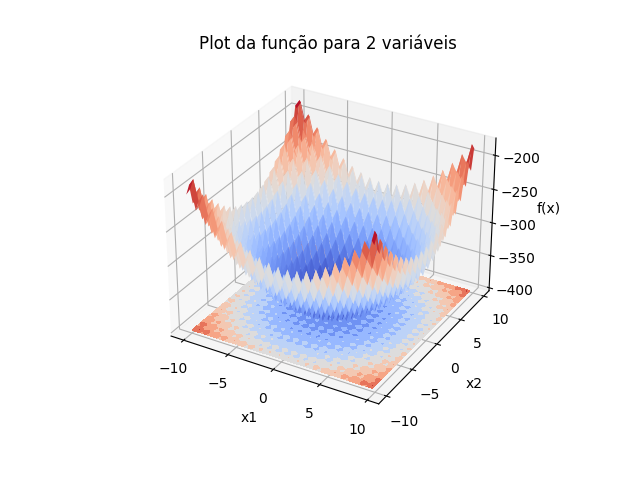

Text(0.5, 0, 'f(x)')

In [6]:
# plot da função para 2 variáveis
%matplotlib notebook

# variáveis
x1 = np.arange(-10, 10, 0.25)
x2 = np.arange(-10, 10, 0.25)
y = np.zeros((len(x1), len(x2)))
for i in range(0, len(x1)):
    for j in range (0, len(x2)):
        y[i][j] = rastrf([x1[i], x2[j]])
        
# grid
x1, x2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

cset = ax.contourf(x1, x2, y, zdir='z', offset=-400, cmap=cm.coolwarm)

ax.set_title('Plot da função para 2 variáveis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

#### Tarefa 2

Devemos desenvolver um PSO  e executá-lo para cada uma das duas funções de teste escolhidas na Tarefa 1 com as configurações abaixo:

[<img src="tabela1.png" width="500px"/>](attachment:tabela1.png)

Primeiramente vamos implementar a função genérica do PSO

In [7]:
def pso(f, p, d, pso_type="gbest", bound=[-100, 100], chi=1, w=1, c1=1, c2=1, comput_budget=100000):
    # f: função objetivo
    # fv: função de atualizão das velocidades
    # p: numero de particulas
    # d: dimensao do problema
    # bound: [min, max] -> limites do espaço de busca
    # chi: parametro de constrição
    # w: peso de inércia
    # c1: coeficiente de aceleração da parecela cognitiva do calculo de velocidade
    # c2: coeficiente de aceleração da parcela social do calculo de velocidade
    # comput_budget: numero maximo de avaliações da função objetivo

    # inicialização de variáveis
    num_eval = 0
    best_pos_x_list = []
    best_pos_fx_list = []
    global_best_position_x = []
    global_best_position_fx = []
    group_best_x = np.zeros((p, d))
    fx = np.inf * np.ones(p)
    t = 0

    # Inicializacão das particulas. Inicialização uniforme no espaço de busca
    x = np.random.uniform(bound[0], bound[1], [p, d])

    # inicialização das velocidades como nulas
    v = np.zeros((p, d))

    # inicio do loop
    while num_eval <= comput_budget:
        best_position_fx = np.inf

        # loop em todas as particulas
        for i in range(0, p):

            # avalia função
            fx[i] = f(x[i])
            num_eval = num_eval + 1

            # seta melhor posicao da iteração
            if fx[i] < best_position_fx:
                best_position_x = x[i]
                best_position_fx = fx[i]

        # após primeiro loop para ter todas as avaliações de função,
        # novo loop para pegar as melhores particulas na vizinhança
        if pso_type == 'lbest': # só é necessario para o lbest
            for i in range(0, p):

                # vizinhança em anel
                if i == 0:
                    N = [p - 1, i, i + 1]
                elif i == p - 1:
                    N = [i - 1, i, 0]
                else:
                    N = [i - 1, i, i + 1]

                # atualiza melhor posição da vizinhança (lbest)
                group_best_fx = min(fx[N])
                group_best_x[i] = np.array(x[fx == group_best_fx][0])

        # todo verificar necessidade
        best_pos_x_list.append(list(best_position_x))
        best_pos_fx_list.append(best_position_fx)

        # Atualiza valores globais de minimo (gbest)
        global_best_fx = min(best_pos_fx_list)
        global_best_x = np.array(best_pos_x_list[best_pos_fx_list.index(global_best_fx)])
        global_best_position_fx.append(global_best_fx)
        global_best_position_x.append(global_best_x)

        # atualização das velocidades e das particulas
        for i in range(0, p):
            if pso_type == "lbest":
                gbp = group_best_x[i]
            else:
                gbp = global_best_position_x[t]
            lbp = best_pos_x_list[t]
            r1 = np.random.random()
            r2 = np.random.random()
            v_cognitive = c1 * r1 * (lbp - x[i])
            v_social = c2 * r2 * (gbp - x[i])
            v[i] = chi * (w * v[i] + v_cognitive + v_social)
            x[i] = x[i] + v[i]

            # aplica limite superior e inferior
            x[i][x[i] > bound[1]] = bound[1]
            x[i][x[i] < bound[0]] = bound[0]

        t = t + 1  # atualiza tempo

    return global_best_position_fx, global_best_position_x, t

Vamos testar a convergência do PSO para 2 variáveis, usando o global best PSO e o local best PSO

In [8]:
# definição de função de plotagem
def pso_surface_plot(s, x, f, title, offset):
    xa = []
    xb = []
    for i in range(len(x)):
        xa.append(x[i][0])
        xb.append(x[i][1])

    # variáveis
    x1 = np.arange(-10, 10, 0.25)
    x2 = np.arange(-10, 10, 0.25)
    y = np.zeros((len(x1), len(x2)))
    for i in range(0, len(x1)):
        for j in range (0, len(x2)):
            y[i][j] = f([x1[i], x2[j]])

    # grid
    x1, x2 = np.meshgrid(x1, x2)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                           linewidth=1, antialiased=True, alpha=.125)

    cset = ax.contourf(x1, x2, y, zdir='z', offset=offset, cmap=cm.coolwarm)
    ax.plot3D(xa, xb, s[:], c='b', marker='*', zorder=10)

    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x)')

<IPython.core.display.Javascript object>


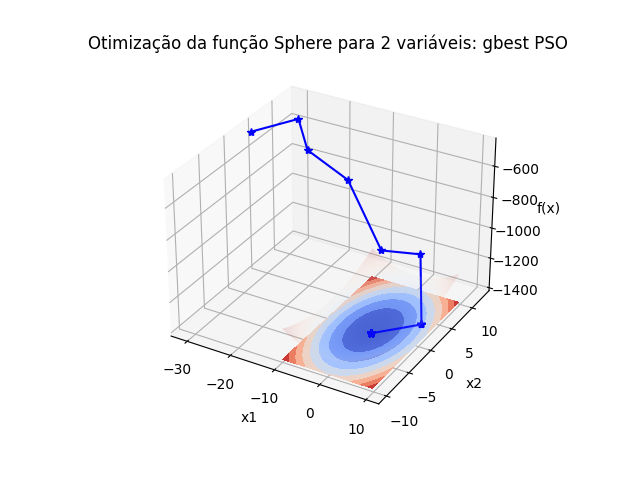

<IPython.core.display.Javascript object>

In [9]:
%matplotlib notebook
bound = [-50, 50]
x, s, it = pso(spheref, 10, 2, "gbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, spheref, 'Otimização da função Sphere para 2 variáveis: gbest PSO', -1400)

x, s, it = pso(spheref, 10, 2, "lbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, spheref, 'Otimização da função Sphere para 2 variáveis: lbest PSO', -1400)


<IPython.core.display.Javascript object>


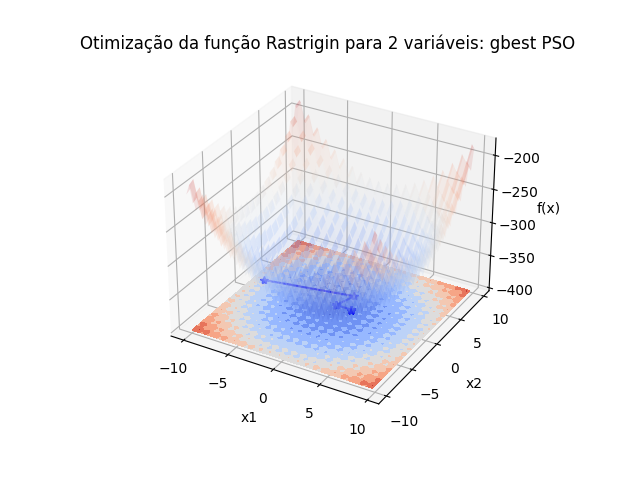

<IPython.core.display.Javascript object>


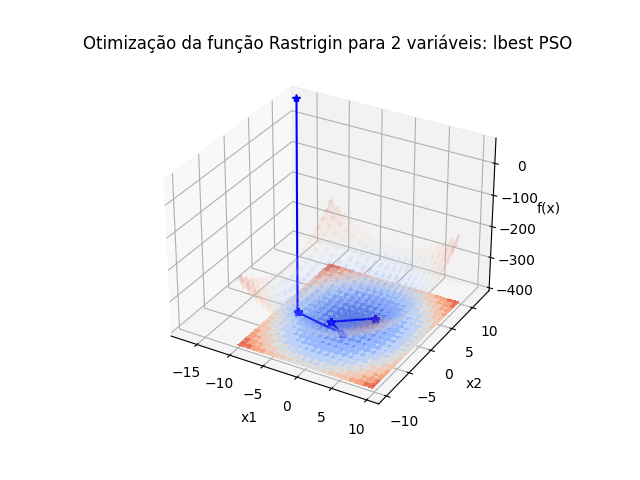

In [11]:
%matplotlib notebook
x, s, it = pso(rastrf, 10, 2, "gbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, rastrf, 'Otimização da função Rastrigin para 2 variáveis: gbest PSO', -400)

x, s, it = pso(rastrf, 10, 2, "lbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, rastrf, 'Otimização da função Rastrigin para 2 variáveis: lbest PSO', -400)

### Tarefa 3

Agora iremos definir o set de hiper-parâmetros do problema e analisar as execuções para a função unimodal e para a função multimodal

#### Analise da função unimodal: Sphere 

In [34]:
# Hiper-parâmetros definidos no enunciado do problema
D = 10 # dimensões
num_exec = 31 # numero de execuções de cada função
comput_budget = 100000 # recurso computacional
bound = [-100, 100] # limite inferior e superior das variaveis do problema

Fora os parâmetros fixados no enunciado do problema, temos outros 3 parâmetros que podem ser configurados. O tamanho da população e as duas constantes do pso, c1 e c2. Para a função sphere, uma função unimodal, é interessante aumentar o peso na velocidade social (c2). Isto irá fazer com que todas as particulas tendam a se mover mais para o melhor ponto encontrado.

Para a definição da população foi considerado o seguinte: Como o problema é unimodal, parece ser mais interessante ter um número maior de iterações em detrimento de uma população maior. Então inicialmente estipulado que 1000 iterações seria um número rasoável para a evolução das particulas. Como temos um orçamento de 100.000 avaliações de função e cada iteração avalia a funçao uma vez para cada particula, podemos ter portanto uma população de 100

In [35]:
# Hiper-parâmetros variáveis
P = 100 # tamanho da população
c1 = 1 # constantes do PSO (entre 1 e 2)
c2 = 2 # constantes do PSO (entre 1 e 2)

In [36]:
# Definição de uma função para multiplas execuções
def multiple_PSO_execution(num_exec, spheref, P, D, PSO_type, bound, chi, w, c1, c2, comput_budget):
    s = []
    for i in range(0, num_exec):
        fx, x, it = pso(spheref, P, D, PSO_type, bound, chi, w, c1, c2, comput_budget)
        s.append(fx[-1]) # armazena apenas ultimo resultado, que é o ponto ótimo encontrado
    return s 

##### Execução e análise para função Sphere

In [37]:
# Definição de função de plotagem
def pso_displot(s1, s2, title):
    sns.set_style("white")
    kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

    plt.figure(figsize=(10,7), dpi= 80)
    label1 = "gbest PSO. mean: " + str(round(np.mean(s_gbest), 2)) + " std: " + str(round(np.std(s_gbest), 2))
    label2 = "lbest PSO. mean: " + str(round(np.mean(s_lbest), 2)) + " std: " + str(round(np.std(s_lbest), 2))
    sns.distplot(s_gbest, color="dodgerblue", label=label1, **kwargs)
    sns.distplot(s_lbest, color="deeppink", label=label2, **kwargs)
    plt.title(title)
    plt.legend();

<IPython.core.display.Javascript object>


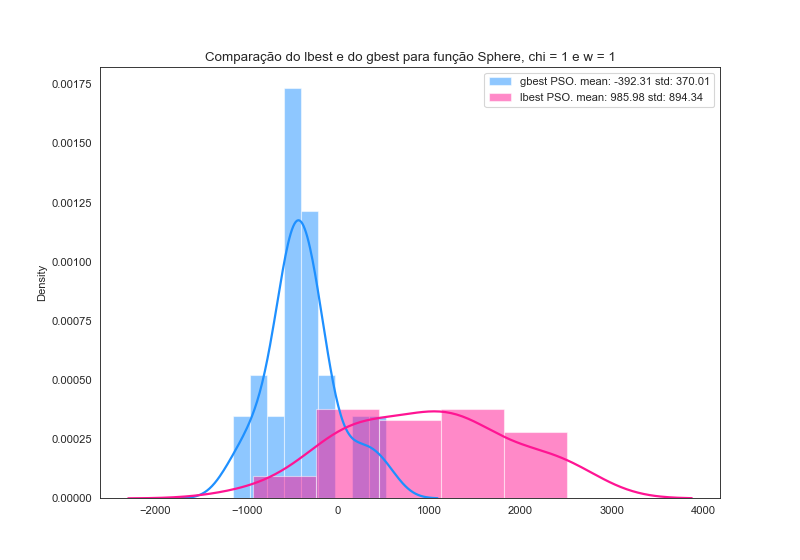

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [38]:
# chi = 1, w = 1
chi = 1
w = 1

s_gbest = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = 1'
pso_displot(s_gbest, s_lbest, title)

<IPython.core.display.Javascript object>


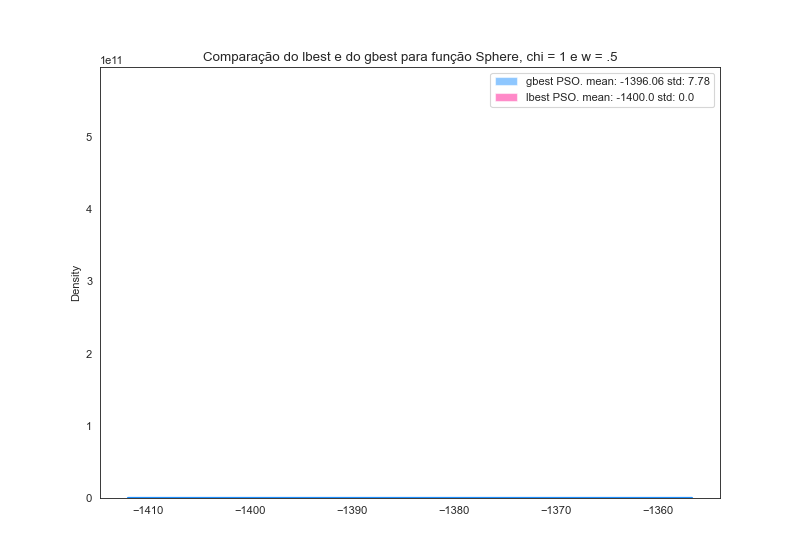

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [39]:
# chi = 1, 0 < w < 1
chi = 1
w = .5

s_gbest = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = .5'
pso_displot(s_gbest, s_lbest, title)

<IPython.core.display.Javascript object>


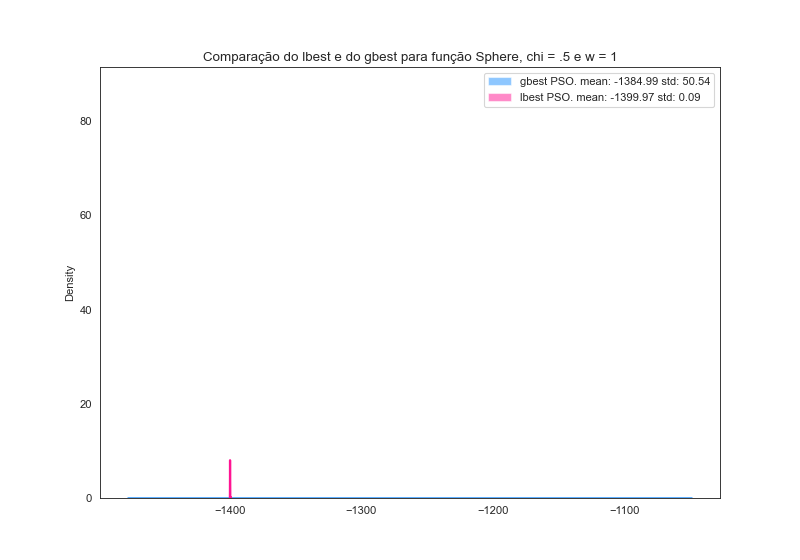

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [40]:
# 0 < chi < 1, w = 1
chi = .5
w = 1

s_gbest = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = .5 e w = 1'
pso_displot(s_gbest, s_lbest, title)

<IPython.core.display.Javascript object>


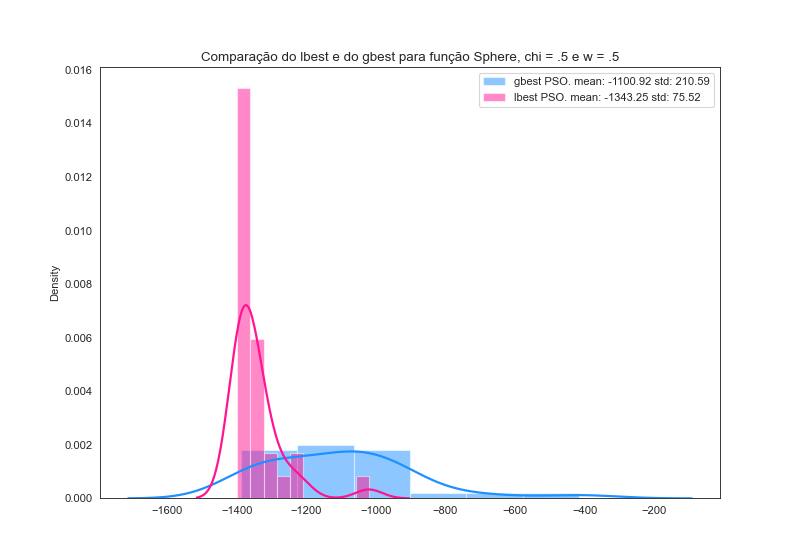

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [41]:
# 0 < chi < 1, 0 < w < 1
chi = .5
w = .5

s_gbest = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = .5 e w = .5'
pso_displot(s_gbest, s_lbest, title)

#### Analise da função unimodal: Rastrigin 

Por ser uma função com vários mínimos, uma população maior pode gerar soluções mais diversas e portanto privilegiar a conversão ao ótimo global. Portanto, para esta função, iremos com uma população maior, de 200 individuos e, portanto, menos iterações. 

Já com relação às constantes c1 e c2 a decisão é por mantê-las iguais em 1.

In [42]:
# Hiper-parâmetros variáveis
P = 200 # tamanho da população
c1 = 1 # constantes do PSO (entre 1 e 2)
c2 = 1 # constantes do PSO (entre 1 e 2)

<IPython.core.display.Javascript object>


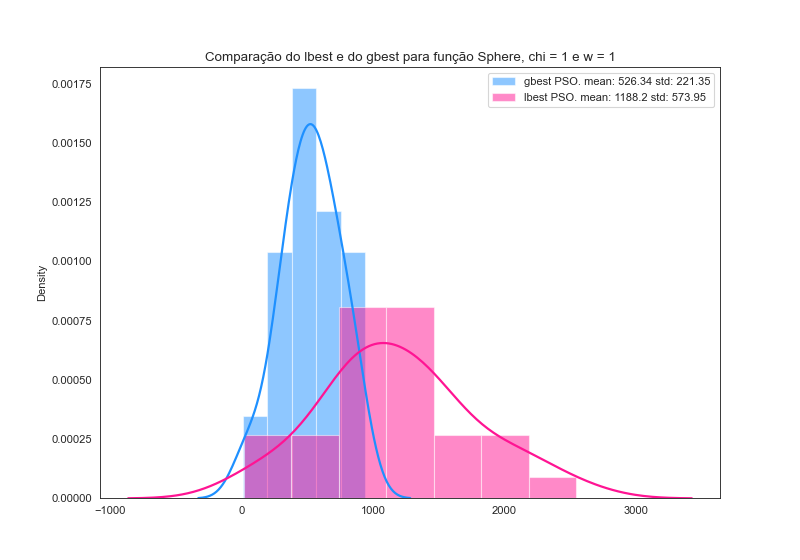

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [43]:
# chi = 1, w = 1
chi = 1
w = 1

s_gbest = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = 1'
pso_displot(s_gbest, s_lbest, title)

<IPython.core.display.Javascript object>


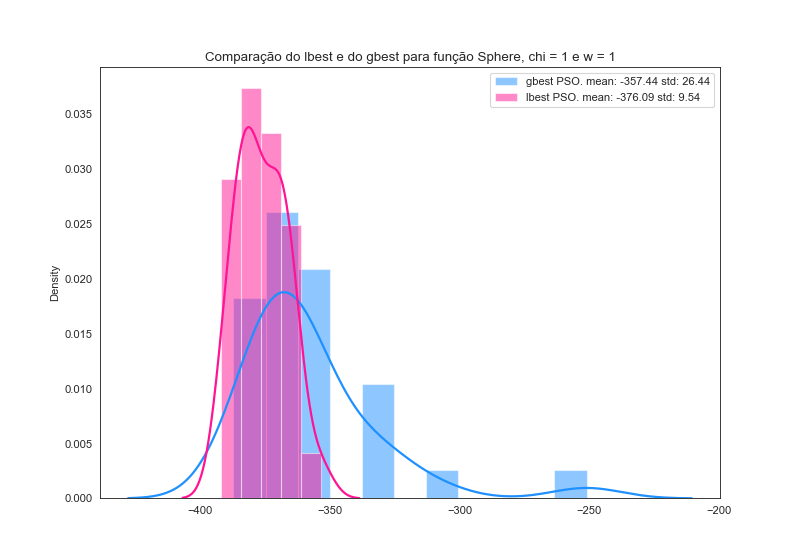

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [44]:
# chi = 1, 0 < w < 1
chi = 1
w = .5

s_gbest = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = 1'
pso_displot(s_gbest, s_lbest, title)

<ipython-input-37-50d559a5aefa>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,7), dpi= 80)


<IPython.core.display.Javascript object>


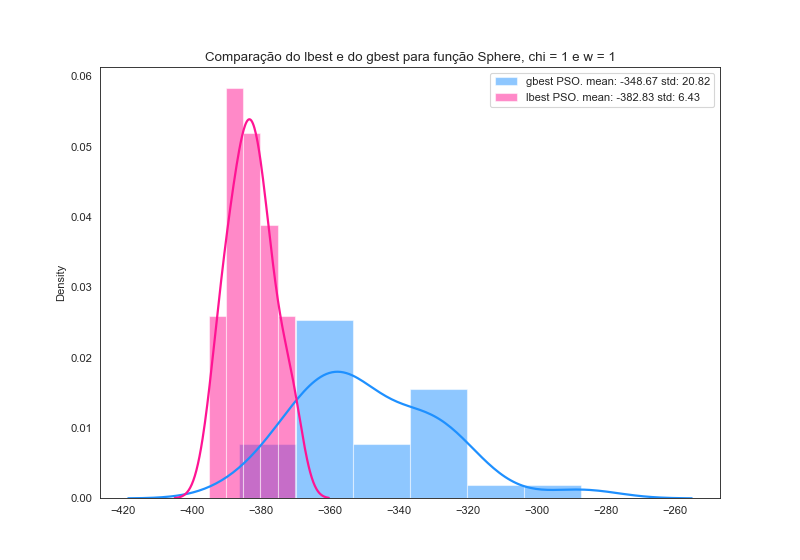

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [45]:
# 0 < chi < 1, w = 1
chi = .5
w = 1

s_gbest = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = 1'
pso_displot(s_gbest, s_lbest, title)

<IPython.core.display.Javascript object>


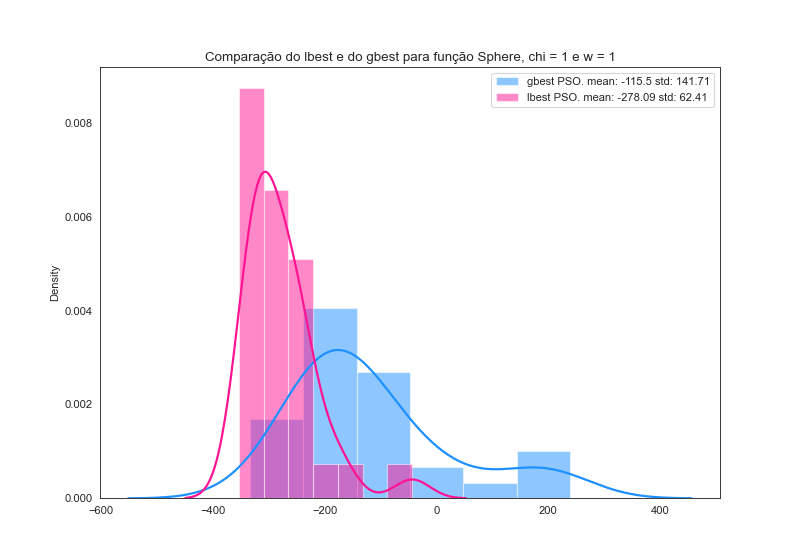

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [46]:
# 0 < chi < 1, 0 < w < 1
chi = .5
w = .5

s_gbest = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbest = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)
title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = 1'
pso_displot(s_gbest, s_lbest, title)